2025-03-01 00:37:42.873717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


    Open   High    Low  Close  per_change     Qty    EPS         PE
0  678.0  666.0  658.0  660.0         0.0  3547.0  17.94  36.789298
1  660.0  660.0  647.0  651.0         0.0  5758.0  17.94  36.287625
2  651.0  655.0  644.0  646.0         0.0  6085.0  17.94  36.008919
3  646.0  651.0  642.0  648.0         0.0  6977.0  17.94  36.120401
4  648.0  651.0  643.0  648.0         0.0  3303.0  17.94  36.120401
Epoch 1/100
21/21 [==============================] - 8s 167ms/step - loss: 0.0352 - val_loss: 0.0102 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 3s 120ms/step - loss: 0.0121 - val_loss: 0.0076 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 2s 109ms/step - loss: 0.0101 - val_loss: 0.0069 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 2s 110ms/step - loss: 0.0089 - val_loss: 0.0066 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 2s 109ms/step - loss: 0.0083 - val_loss: 0.0062 - lr: 0.0010
Epoch 6/100
21/21 [===

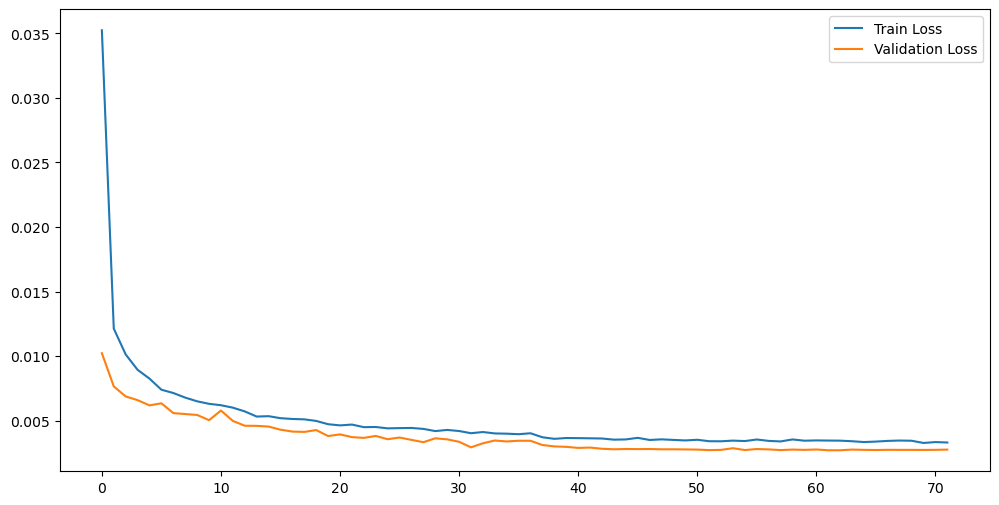

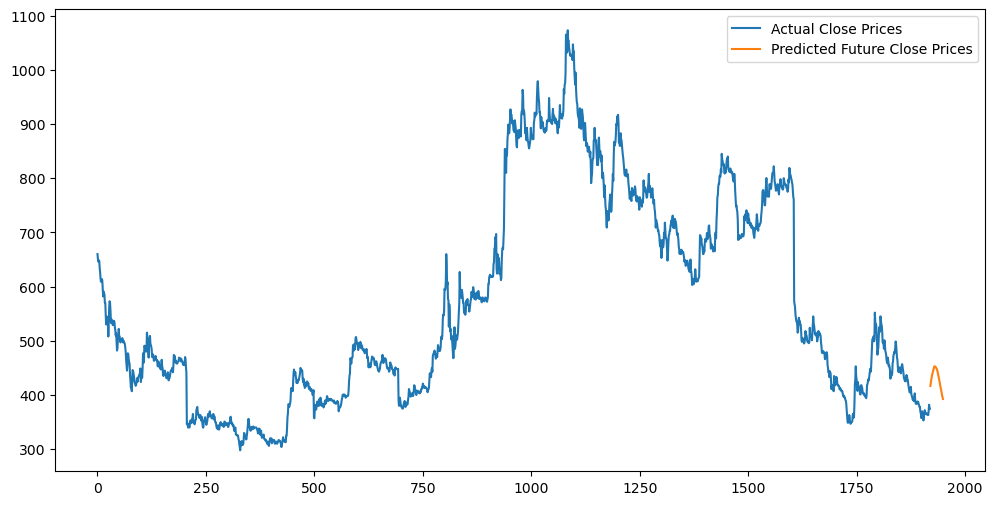

          Open        High         Low       Close  per_change           Qty  \
0   412.351166  416.085999  413.152313  416.588257    0.132707  36543.218750   
1   418.099548  421.254669  418.183319  422.331696    0.110837  35560.503906   
2   423.835175  426.391327  423.196686  427.693512    0.107879  34994.644531   
3   428.895660  431.275055  427.747925  432.552429    0.088712  34705.851562   
4   433.344025  435.602783  431.574158  436.536346    0.088592  34798.550781   
5   436.289581  439.659088  434.762512  440.135956    0.041446  34938.449219   
6   438.212036  443.825928  438.117767  443.308563    0.079061  36456.093750   
7   439.681549  448.225525  441.884430  446.530396    0.158175  39082.316406   
8   441.386017  452.276337  445.717957  449.549194    0.239083  41921.753906   
9   443.190460  456.011353  449.725800  452.925598    0.256129  44223.453125   
10  446.747528  454.938538  449.414032  452.368927    0.058721  39897.851562   
11  447.222748  455.517914  450.094238  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load your data
df = pd.read_csv('sorted_stock_data_cleaned_nica.csv')  # Replace with your file
print(df.head())

# Ensure all 8 columns are present (adjust if needed)
feature_columns = ['Open', 'High', 'Low', 'Close', 'per_change', 'Qty', 'EPS', 'PE']  # Your 8 features
data = df[feature_columns].values

# Scale all 8 features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Sequence creation function
def create_sequences_multivariate(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])   # n_steps timesteps, each with 8 features
        y.append(data[i+n_steps])      # Predict all 8 features at next step
    return np.array(X), np.array(y)

# Parameters
n_steps = 60  # Past 60 days used for prediction

# Create sequences
X, y = create_sequences_multivariate(scaled_data, n_steps)

# Train-test split
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_steps, 8)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(8))  # Predict all 8 features at once

model.compile(optimizer='adam', loss='mse')

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks)

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Function to predict future days recursively (all 8 features)
def predict_future_multivariate(model, data, scaler, n_steps, future_days):
    predicted = []
    current_sequence = data[-n_steps:]  # Last window of data

    for _ in range(future_days):
        prediction = model.predict(current_sequence.reshape(1, n_steps, 8), verbose=0)
        predicted.append(prediction[0])

        # Append predicted row to current sequence for next prediction
        current_sequence = np.vstack([current_sequence[1:], prediction])

    # Inverse transform all predicted data (8 features)
    predicted_array = np.array(predicted)
    predicted_prices = scaler.inverse_transform(predicted_array)
    return predicted_prices

# Predict next 30 days
future_days = 30
future_prices = predict_future_multivariate(model, scaled_data, scaler, n_steps, future_days)

# Plot actual vs future Close prices
actual_close_prices = df['Close'].values

plt.figure(figsize=(12, 6))
plt.plot(actual_close_prices, label='Actual Close Prices')
plt.plot(range(len(actual_close_prices), len(actual_close_prices) + future_days), future_prices[:, 3], label='Predicted Future Close Prices')
plt.legend()
plt.show()

# Print predicted future prices (all features for each day)
future_df = pd.DataFrame(future_prices, columns=feature_columns)
print(future_df)

# Save to CSV if needed
future_df.to_csv('predicted_future_prices.csv', index=False)
